In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy import stats
from scipy.stats import mode
import seaborn as sns
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore")
from scipy.stats import chisquare

In [5]:
!mkdir output/04B.pair_annotation

mkdir: cannot create directory ‘output/04B.pair_annotation’: File exists


In [6]:
snps = pd.read_csv("output/03.annotation/snps_with_all_annotation.csv", index_col=0)
snps_columns_to_keep = [
    "pos", 
    "gene_name", 
    "gene_id", 
    "is_lineage",
    "in_antigen_epitope",
    "in_antigen_protein", 
    "in_known_ABR_position",
    "known_drug", 
    "in_possible_ABR_gene", 
    "possible_drug"

]

# Add gene and lineage  annotation to the results
results = pd.read_csv("output/02B.comutation_pvalues/results_file_allpairs.csv")
results = results.merge(snps[snps_columns_to_keep], left_on="position_i", right_on="pos")
results = results.merge(snps[snps_columns_to_keep], left_on="position_j", right_on="pos", suffixes=["_i", "_j"])
results.columns

print("total pairs", len(results))
print("total non-lineage pairs", len(results.query("not is_lineage_i and not is_lineage_j")))

results = results.query("not is_lineage_i and not is_lineage_j")

results = results[[
   'position_i', 'gene_name_i','position_j', 'gene_name_j',
    'n_mutations_i',
   'n_mutations_j', 'n_branches_with_i', 'n_branches_with_j',
   'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i', 'n_muts_same_branch',
   'n_branch_with_i_no_j', 'n_branch_with_j_no_i', 'n_branch_i_and_j',
   'pval_beta_i_on_j', 'BH_critical_value', 'pval_beta_i_on_j_BH_sig',
    'is_lineage_i','is_lineage_j',
    'gene_id_i', 'gene_id_j', 
    "in_antigen_epitope_i",
    "in_antigen_protein_i", 
    "in_known_ABR_position_i",
    "known_drug_i", 
    "in_possible_ABR_gene_i", 
    "possible_drug_i",
    "in_antigen_epitope_j",
    "in_antigen_protein_j", 
    "in_known_ABR_position_j",
    "known_drug_j", 
    "in_possible_ABR_gene_j", 
    "possible_drug_j"
]]
results.to_csv("output/04B.pair_annotation/results_allpairs_annotated.csv")

print("total_significant", len(results.query("pval_beta_i_on_j_BH_sig")))
results.query("pval_beta_i_on_j_BH_sig").to_csv("output/04B.pair_annotation/results_significant_annotated.csv")

total pairs 152224
total non-lineage pairs 135540
total_significant 62562


In [7]:
63271/139048

0.4550299177262528

## Overall analysis of hits

In [8]:
def annotate(top_hits):
    def _separate_hits(logic_columns, current_df):
        is_hit = np.sum(current_df[logic_columns].values, axis=1) > 0

        hit_df = current_df.iloc[is_hit, :]
        current_df = current_df.iloc[~is_hit, :]
        return hit_df, current_df

    # start with the df of top hits. Get just the known antibiotic hits
    top_hits["annotation"] = 'other'
    logic_columns = ["in_known_ABR_position_i", "in_known_ABR_position_j"]

    antibiotic_hits, current_df = _separate_hits(logic_columns, top_hits)

    # if both are antibiotic, annotate that
    antibiotic_hits.loc[
        np.logical_and(
            antibiotic_hits.in_known_ABR_position_i.values, 
            antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "between_known_AB"

    # if just one, annotate that
    antibiotic_hits.loc[
        np.logical_and(
            antibiotic_hits.in_known_ABR_position_i.values, 
            ~antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "known_AB_second"

    antibiotic_hits.loc[
        np.logical_and(
            ~antibiotic_hits.in_known_ABR_position_i.values, 
            antibiotic_hits.in_known_ABR_position_j.values
        ), 
        "annotation"
    ] = "known_AB_first"

    # Then get the antigen proteins
    logic_columns = ['in_antigen_protein_i','in_antigen_protein_j',]

    antigen_hits, current_df = _separate_hits(logic_columns, current_df)

    # if just one, annotate that
    antigen_hits.loc[
        np.logical_or(
            antigen_hits.in_antigen_protein_i.values, 
            antigen_hits.in_antigen_protein_j.values
        ), 
        "annotation"
    ] = "one_antigen"

    antigen_hits.loc[
        np.logical_and(
            antigen_hits.in_antigen_protein_i.values, 
            antigen_hits.in_antigen_protein_j.values
        ), 
        "annotation"
    ] = "both_antigen"

    # then get the maybe antibiotic hits
    logic_columns = ["in_possible_ABR_gene_i", "in_possible_ABR_gene_j"]

    maybe_antibiotic_hits, current_df = _separate_hits(logic_columns, current_df)

    # if both are antibiotic, annotate that
    maybe_antibiotic_hits.loc[
        np.logical_and(
            maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "between_maybe_AB"

    # if just one, annotate that
    maybe_antibiotic_hits.loc[
        np.logical_and(
            maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            ~maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "maybe_AB_second"

    maybe_antibiotic_hits.loc[
        np.logical_and(
            ~maybe_antibiotic_hits.in_possible_ABR_gene_i.values, 
            maybe_antibiotic_hits.in_possible_ABR_gene_j.values
        ), 
        "annotation"
    ] = "maybe_AB_first"

    return pd.concat([antigen_hits, antibiotic_hits, maybe_antibiotic_hits, current_df])

In [9]:
top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated.csv")
top_hits = annotate(top_hits)
top_hits.to_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv")
top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv", index_col=0)

In [10]:
print(top_hits.groupby("annotation").size())

annotation
between_known_AB     1150
between_maybe_AB     1592
both_antigen         4105
known_AB_first       3248
known_AB_second      2815
maybe_AB_first       3229
maybe_AB_second      1500
one_antigen         16026
other               28897
dtype: int64


In [11]:
top_hits.sort_values("pval_beta_i_on_j")[[
    "position_i",  "gene_name_i", "position_j", "gene_name_j", 
    "n_mutations_i", "n_mutations_j", "n_muts_same_branch", "pval_beta_i_on_j", "annotation"
]].head(50)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_muts_same_branch,pval_beta_i_on_j,annotation
107,761155,rpoB,2155168,katG,1487,1811,569,0.000000e+00,between_known_AB
0,105060,Rv0095c,105063,Rv0095c,345,333,324,0.000000e+00,other
2705,1341114,esxL,1341120,esxL,181,218,164,4.940656e-323,both_antigen
1929,2197331,Rv1945,2197332,Rv1945,123,125,121,4.850264e-275,both_antigen
325,3847215,PPE59,3847221,PPE59,149,134,125,9.116068e-269,other
11337,3841652,None,3841654,None,114,114,113,6.451416e-262,other
10125,1341099,esxL,1341114,esxL,194,181,133,3.728245e-257,both_antigen
2706,1341099,esxL,1341120,esxL,194,218,132,7.819885e-244,both_antigen
11517,1339435,PPE18,1339436,PPE18,105,113,103,2.841233e-236,both_antigen
11164,1339432,PPE18,1339435,PPE18,109,105,102,3.577330e-235,both_antigen


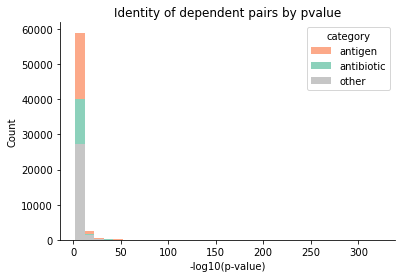

In [12]:

# Create beautiful perfect color palette
pal = sns.color_palette("Set2")
figure = plt.figure()
ax = figure.gca()
top_hits["log_pval"] = -np.log10(top_hits.pval_beta_i_on_j)
for_display = top_hits
for_display["category"] = for_display.annotation
for_display["category"] = ["antibiotic" if x in ["known_AB_second", "between_known_AB", "known_AB_first", "maybe_AB_second", "between_maybe_AB", "maybe_AB_first"] else x for x in for_display.category]
for_display["category"] = ["antigen" if x in ["one_antigen", "both_antigen"] else x for x in for_display.category]

sns.histplot(
    data = for_display, x="log_pval", multiple='stack',
    hue="category", 
    binwidth=10, 
    log_scale=[False,False], 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
               "other":pal[7]
              },
    linewidth=0
)
ax.set_xlabel("-log10(p-value)")
ax.set_title("Identity of dependent pairs by pvalue")
sns.despine()
#plt.savefig("figures/identity_by_occurrence.pdf")

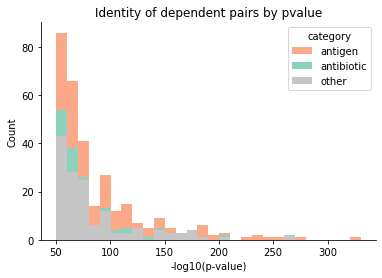

In [13]:

figure = plt.figure()
ax = figure.gca()
#top_hits["log_pval"] = -np.log10(top_hits.pval_beta_i_on_j)

for_display = for_display.query("log_pval > 50")

sns.histplot(
    data = for_display, x="log_pval", multiple='stack',
    hue="category", 
    binwidth=10, 
    log_scale=[False,False], 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
               "other":pal[7]
              },
    linewidth=0
)
ax.set_xlabel("-log10(p-value)")
ax.set_title("Identity of dependent pairs by pvalue")
# ax.set_xlim([20,250])
# ax.set_ylim([0,3000])
sns.despine()
#plt.savefig("figures/identity_by_occurrence.pdf")

In [14]:
def dist(p1,p2):
    
    total_nucleotides = 4411532    

    max_dist = int(total_nucleotides / 2)
    # accounts for circularization of genome
    d1 = np.abs(p1 - p2)
    
    #print(i,j,d1)
    if d1 > max_dist:
        i,j=sorted([p1,p2])
        #print("too_far!", d1)
        i = i + total_nucleotides
        d1 = i-j
        #print("new distance", d1)
        
    return d1


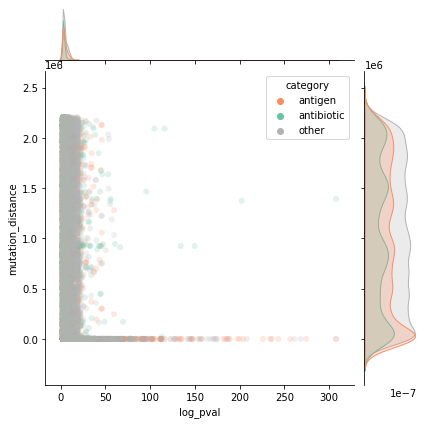

In [15]:
import sys
for_display = top_hits
for_display["category"] = for_display.annotation
for_display["category"] = ["antibiotic" if x in ["known_AB_second", "between_known_AB", "known_AB_first", "maybe_AB_second", "between_maybe_AB", "maybe_AB_first"] else x for x in for_display.category]
for_display["category"] = ["antigen" if x in ["one_antigen", "both_antigen"] else x for x in for_display.category]

for_display["mutation_distance"]=[dist(x,y) for x,y in zip(for_display.position_i, for_display.position_j)]
for_display["log_pval"] = -np.log10(for_display.pval_beta_i_on_j + sys.float_info.min)
sns.jointplot(
    data = for_display, x="log_pval",  y="mutation_distance",
    hue="category", 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
               "other":pal[7]
              },
    linewidth=0,
    alpha=0.2
)                         

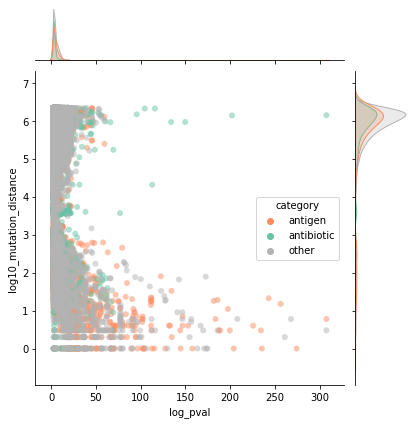

In [16]:
import sys
for_display["log2_mutation_distance"]=[np.log2(d) for d in for_display.mutation_distance]
for_display["log10_mutation_distance"]=[np.log10(d) for d in for_display.mutation_distance]
for_display["log_pval"] = -np.log10(for_display.pval_beta_i_on_j + sys.float_info.min)

sns.jointplot(
    data = for_display, x="log_pval",  y="log10_mutation_distance",
    hue="category", 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
              "between":pal[2], 
               "other":pal[7]
              },
    linewidth=0,
    alpha=0.5
)     

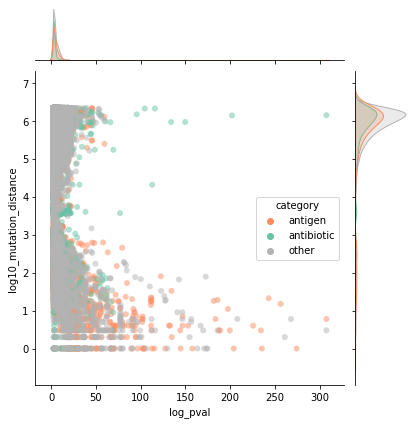

In [17]:
import sys
for_display = top_hits
for_display["category"] = for_display.annotation
for_display["category"] = ["antibiotic" if x in ["known_AB_second", "between_known_AB", "known_AB_first", "maybe_AB_second", "between_maybe_AB", "maybe_AB_first"] else x for x in for_display.category]
for_display["category"] = ["antigen" if x in ["one_antigen", "both_antigen"] else x for x in for_display.category]


#for_display = for_display.query("log_pval > 50")
for_display["log2_mutation_distance"]=[np.log2(dist(x,y)) for x,y in zip(for_display.position_i, for_display.position_j)]
for_display["log10_mutation_distance"]=[np.log10(d) for d in for_display.mutation_distance]
for_display["mutation_distance"]=[dist(x,y) for x,y in zip(for_display.position_i, for_display.position_j)]
for_display["log_pval"] = -np.log10(for_display.pval_beta_i_on_j + sys.float_info.min)

sns.jointplot(
    data = for_display, x="log_pval",  y="log10_mutation_distance",
    hue="category", 
    palette = {"antibiotic":pal[0],
               "antigen":pal[1],
              "between":pal[2], 
               "other":pal[7]
              },
    linewidth=0,
    alpha=0.5
)     

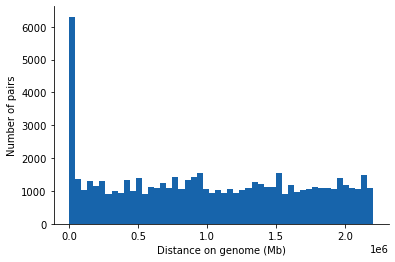

In [18]:

pal = sns.color_palette("Blues",4)

for_display = top_hits
for_display["mutation_distance"] = [dist(x,y) for x,y in zip(for_display.position_i, for_display.position_j)]
figure = plt.figure()
ax = figure.gca()

ax.hist(for_display.mutation_distance, 50, color=pal[3])
plt.xlabel("Distance on genome (Mb)")
plt.ylabel("Number of pairs")
sns.despine()
#plt.show()
plt.savefig("figures/simultaneous_mutations_distance.pdf")

## Characterization of simultaneous, proximal pairs

In [19]:
top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated.csv")
top_hits = annotate(top_hits)
top_hits["mutation_distance"] = [dist(x,y) for x,y in zip(top_hits.position_i, top_hits.position_j)]

top_hits.to_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv")

top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv", index_col=0)

In [20]:
# Are the near distance hits more likely to be genic or intergenic? 

all_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated.csv", index_col=0)
all_hits["mutation_distance"] = [dist(x,y) for x,y in zip(all_hits.position_i, all_hits.position_j)]

near_hits = all_hits.query('mutation_distance <= 100')
far_hits = all_hits.query('mutation_distance > 100')

print("number of close pairs", len(near_hits), "number of far pairs", len(far_hits))
N = len(near_hits)
print("fraction intergenic", len(near_hits.query("gene_name_i == gene_name_j == 'None'"))/N, "\n",
      "fraction genic", len(near_hits.query("gene_name_i == gene_name_j != 'None'"))/N,"\n",
      "fraction not same gene/one genic one intergenic", len(near_hits.query("gene_name_i != gene_name_j"))/N,"\n"
     )


number of close pairs 2467 number of far pairs 60095
fraction intergenic 0.14916903121199837 
 fraction genic 0.8305634373733279 
 fraction not same gene/one genic one intergenic 0.020267531414673693 



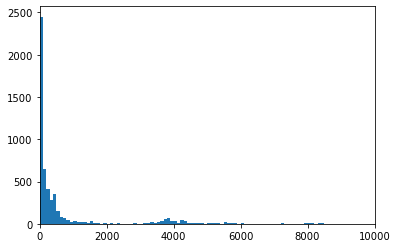

In [21]:
# At what distance are the pairs actually enriched? 
# Bin size of 100
plt.xlim([0,10000])
plt.hist(top_hits.mutation_distance, bins = np.arange(0,10000,100))
plt.savefig("figures/enrichment_by_distance.pdf")

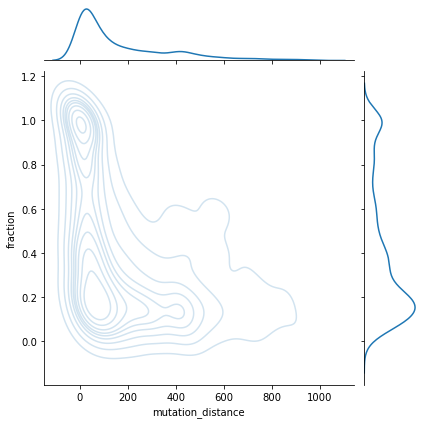

In [22]:
# fraction of times a mutation happens simultaneously compared to the # of times
# the less frequent mutation happens
top_hits["fraction"] = top_hits.n_muts_same_branch / pd.concat([top_hits.n_mutations_i,top_hits.n_mutations_j], axis=1).min(axis=1)

sns.jointplot(data = top_hits.query('mutation_distance<1000'),
                                       x="mutation_distance", 
              y="fraction", linewidth=0, alpha=0.2, kind='kde')
plt.savefig("figures/fraction_simultaneous_vs_distance_density.pdf")

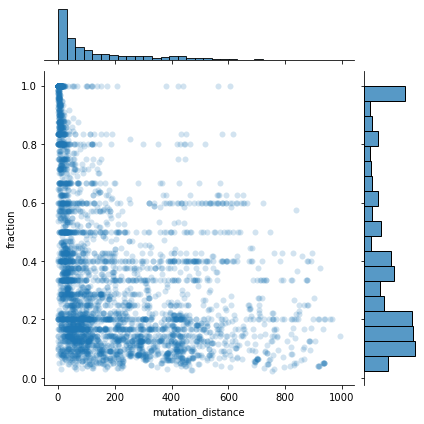

In [23]:

sns.jointplot(data = top_hits.query('mutation_distance<1000'),
                                       x="mutation_distance", 
              y="fraction", linewidth=0, alpha=0.2)
plt.savefig("figures/fraction_simultaneous_vs_distance.pdf")

## Enrichment statistics

In [24]:

all_hits = pd.read_csv("output/04B.pair_annotation/results_allpairs_annotated.csv")

all_hits = annotate(all_hits)
all_hits.to_csv("output/04B.pair_annotation/results_allpairs_annotation_withcategories.csv")
print(all_hits.groupby("annotation").size())

annotation
between_known_AB     3329
between_maybe_AB     2289
both_antigen        10104
known_AB_first      13035
known_AB_second     14552
maybe_AB_first       5946
maybe_AB_second      2842
one_antigen         38901
other               44542
dtype: int64


#### Question 1: are the overlapping hits an enrichment in some way based on our expectation from the distribution of SNPs?

In [34]:

top_hits = pd.read_csv("output/04B.pair_annotation/results_significant_annotated_with_categories.csv", index_col=0)

all_hits = pd.read_csv("output/04B.pair_annotation/results_allpairs_annotated.csv")

all_hits = annotate(all_hits)
all_hits.to_csv("output/04B.pair_annotation/results_allpairs_annotation_withcategories.csv")
print(all_hits.groupby("annotation").size())

## Actual numbers: 162 epitopes, 804 antigens, 250 known resistance, 813 possible resistance, 2747 no category
total_snps = 4735

p_epitope = 162/total_snps
p_antigen = 804/total_snps
p_known_R = 250/total_snps
p_possible_R = (813-250)/total_snps
p_other = (total_snps - 804 - 813)/total_snps

# bang this out
e_between_known_AB = p_known_R * p_known_R
e_between_maybe_AB = p_possible_R * p_possible_R
e_both_antigen = p_antigen * p_antigen

e_known_AB_first = p_known_R * (1-p_known_R)
e_known_AB_second = p_known_R * (1-p_known_R)

e_maybe_AB_first = p_possible_R * (p_other)
e_maybe_AB_second = p_possible_R * (p_other)

e_one_antigen = 2 * p_antigen * (p_other + p_possible_R)
e_other = p_other * p_other


top_hits_values = all_hits.groupby("annotation").size()
labels = all_hits.groupby("annotation").size().index

all_hits_expectation = np.array([e_between_known_AB, e_between_maybe_AB, e_both_antigen, e_known_AB_first, 
                        e_known_AB_second, e_maybe_AB_first, e_maybe_AB_second, e_one_antigen, e_other]) * len(all_hits)

## Table of nice results

result_df = pd.DataFrame({
                          "actual_pair_freq": top_hits_values, 
                          "expected_pair_freq": all_hits_expectation})
print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

print(result_df)
result_df1 = result_df
result_df1["chi_square"] = chisquare(top_hits_values,  f_exp=all_hits_expectation)[0]
result_df1["p_value"] = chisquare(top_hits_values,  f_exp=all_hits_expectation)[1]
result_df1["category"] = result_df1.index
result_df1.to_csv("output/04B.chisquare_all_pairs_vs_expected.csv")

annotation
between_known_AB     3329
between_maybe_AB     2289
both_antigen        10104
known_AB_first      13035
known_AB_second     14552
maybe_AB_first       5946
maybe_AB_second      2842
one_antigen         38901
other               44542
dtype: int64
Power_divergenceResult(statistic=59095.701051273565, pvalue=0.0)
                  actual_pair_freq  expected_pair_freq
annotation                                            
between_known_AB              3329          377.839651
between_maybe_AB              2289         1916.215304
both_antigen                 10104         3907.865538
known_AB_first               13035         6778.443347
known_AB_second              14552         6778.443347
maybe_AB_first                5946        10612.361132
maybe_AB_second               2842        10612.361132
one_antigen                  38901        35783.216534
other                        44542        58773.254013


In [35]:
from scipy.stats import chisquare

top_hits_values = top_hits.groupby("annotation").size().values
all_hits_expectation = all_hits.groupby("annotation").size().values / len(all_hits) * len(top_hits)

print(chisquare(top_hits_values,  f_exp=all_hits_expectation))

## Table of nice results

result_df = pd.DataFrame({ 
    "category": top_hits.groupby("annotation").size().index,
    "actual_hit_freq": top_hits_values, 
    "expected_hit_freq": all_hits_expectation})

print(result_df)
result_df2 = result_df

Power_divergenceResult(statistic=7677.218081238885, pvalue=0.0)
           category  actual_hit_freq  expected_hit_freq
0  between_known_AB             1150        1536.586233
1  between_maybe_AB             1592        1056.547278
2      both_antigen             4105        4663.763081
3    known_AB_first             3248        6016.642098
4   known_AB_second             2815        6716.852767
5    maybe_AB_first             3229        2744.530412
6   maybe_AB_second             1500        1311.798761
7       one_antigen            16026       17955.764807
8             other            28897       20559.514564


In [36]:
 top_hits.query("mutation_distance < 100").groupby("annotation").size()

annotation
between_known_AB      35
between_maybe_AB     194
both_antigen        1293
known_AB_first         5
known_AB_second        9
one_antigen           17
other                897
dtype: int64

In [37]:
top_hits.iloc[0:100].groupby("annotation").size()

annotation
both_antigen    30
one_antigen     70
dtype: int64

In [38]:
top_hits.groupby("annotation").size()

annotation
between_known_AB     1150
between_maybe_AB     1592
both_antigen         4105
known_AB_first       3248
known_AB_second      2815
maybe_AB_first       3229
maybe_AB_second      1500
one_antigen         16026
other               28897
dtype: int64

In [39]:
from scipy.stats import chisquare

top_hits=top_hits.sort_values("pval_beta_i_on_j")

top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()
all_hits_expectation = top_hits.groupby("annotation").size() / len(top_hits) * 100

print(chisquare([  8, 0, 51,  0, 0, 0, 0,  0, 41],  f_exp=all_hits_expectation))

## Table of nice results


result_df = pd.DataFrame({ 
    #"category": top_hits.groupby("annotation").size().index,
    "actual_top_hit_freq": top_hits_values, 
    "expected_top_hit_freq": all_hits_expectation})

print(result_df)
result_df3 = result_df
result_df3["category"] = result_df3.index

Power_divergenceResult(statistic=367.61456525058435, pvalue=1.5687570813247688e-74)
                  actual_top_hit_freq  expected_top_hit_freq
annotation                                                  
between_known_AB                  8.0               1.838177
between_maybe_AB                  NaN               2.544676
both_antigen                     54.0               6.561491
known_AB_first                    NaN               5.191650
known_AB_second                   NaN               4.499536
maybe_AB_first                    NaN               5.161280
maybe_AB_second                   NaN               2.397622
one_antigen                       NaN              25.616189
other                            38.0              46.189380


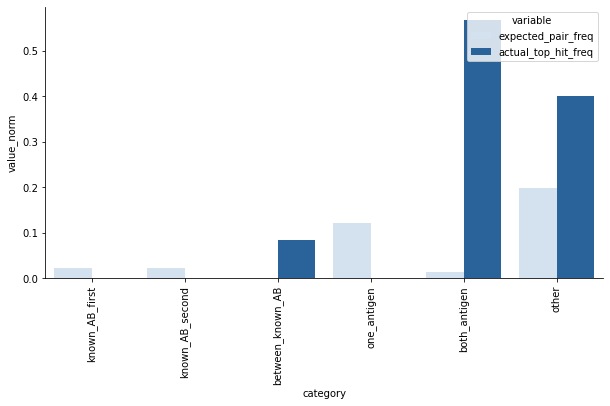

In [40]:
### Combine all three into bar plot
def _process_result_df(result_df):
    cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
    result_df = result_df.query("category not in @cats_to_remove")

    desired_order = ["known_AB_first", "known_AB_second", "between_known_AB", "one_antigen","both_antigen",  "other"]


    to_plot = result_df.melt(["category"])
    to_plot["category_sorter"] = [desired_order.index(x) for x in to_plot.category]
    #to_plot["value"] = [np.log10(x) for x in to_plot.value]

    # normalize the result dataframe
    to_plot["value_norm"] = to_plot.value / (to_plot.value.sum()/2)
    
    return to_plot

pal = sns.color_palette("Blues",4)

toplot1 = _process_result_df(result_df1)
toplot2 = _process_result_df(result_df2)
toplot3 = _process_result_df(result_df3)

to_plot = pd.concat([toplot1, toplot2, toplot3])

categories_to_keep = ["expected_pair_freq", "actual_top_hit_freq"]
to_plot = to_plot.query("variable in @categories_to_keep")

desired_order = ["expected_pair_freq", "actual_pair_freq", "actual_hit_freq", "actual_top_hit_freq"]
to_plot["sorter"] = [desired_order.index(x) for x in to_plot.variable]
to_plot = to_plot.sort_values(["sorter", "category_sorter"])


fig= plt.figure(figsize=(10,5))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value_norm', hue='variable',
            palette=[pal[0], pal[3]]
            
           )
plt.xticks(rotation=90)
#cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

sns.despine()
plt.savefig("figures/simultaneous_mutations_category.pdf")

## Repeat enrichment analysis treating the proximal mutations as separate

In [41]:
all_hits["mutation_distance"]=[dist(x,y) for x,y in zip(all_hits.position_i, all_hits.position_j)]

all_hits_close = all_hits.query("mutation_distance <= 100")
all_hits_far = all_hits.query("mutation_distance > 100")
print(len(all_hits_close), len(all_hits_far))

2708 132832


In [42]:
top_hits_values = all_hits_close.groupby("annotation").size()
top_hits_values

annotation
between_known_AB      69
between_maybe_AB     199
both_antigen        1421
known_AB_first        15
known_AB_second       19
one_antigen           37
other                948
dtype: int64

In [43]:

# need to manually define to ensure that the 0's are in place
top_hits_values = [  69,  199, 1421,   15,   19,  0, 0, 37, 1110]
labels = all_hits_close.groupby("annotation").size().index

all_hits_close_expectation = np.array([
    e_between_known_AB, e_between_maybe_AB, e_both_antigen, e_known_AB_first, 
    e_known_AB_second, e_maybe_AB_first, e_maybe_AB_second, e_one_antigen, e_other
]) * np.sum(top_hits_values)

## Table of nice results

result_df = pd.DataFrame({
                          "actual_pair_freq": top_hits_values, 
                          "expected_pair_freq": all_hits_close_expectation})
print(chisquare(top_hits_values,  f_exp=all_hits_close_expectation))

print(result_df)
results_df1_close = result_df
#result_df1_close["category"] = 

Power_divergenceResult(statistic=24099.4924134044, pvalue=0.0)
   actual_pair_freq  expected_pair_freq
0                69            8.000589
1               199           40.575018
2              1421           82.747337
3                15          143.530562
4                19          143.530562
5                 0          224.712088
6                 0          224.712088
7                37          757.693902
8              1110         1244.497853


In [44]:
top_hits_values = all_hits_far.groupby("annotation").size()

labels = all_hits_far.groupby("annotation").size().index

all_hits_far_expectation = np.array([e_between_known_AB, e_between_maybe_AB, e_both_antigen, e_known_AB_first, 
                        e_known_AB_second, e_maybe_AB_first, e_maybe_AB_second, e_one_antigen, e_other]) * len(all_hits_far)

## Table of nice results

result_df = pd.DataFrame({
                          "actual_pair_freq": top_hits_values, 
                          "expected_pair_freq": all_hits_far_expectation})
print(chisquare(top_hits_values,  f_exp=all_hits_far_expectation))

print(result_df)
results_df1_far = result_df

Power_divergenceResult(statistic=55434.47445757555, pvalue=0.0)
                  actual_pair_freq  expected_pair_freq
annotation                                            
between_known_AB              3260          370.290664
between_maybe_AB              2090         1877.930583
both_antigen                  8683         3829.788957
known_AB_first               13020         6643.014510
known_AB_second              14533         6643.014510
maybe_AB_first                5946        10400.333141
maybe_AB_second               2842        10400.333141
one_antigen                  38864        35068.291417
other                        43594        57599.003077


In [45]:

top_hits=all_hits_close.sort_values("pval_beta_i_on_j")

top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()

all_hits_expectation = all_hits_close.groupby("annotation").size() / len(top_hits) * 100

print(chisquare([  0, 0, 56,  0, 0,  0, 44],  f_exp=all_hits_expectation))

## Table of nice results


result_df = pd.DataFrame({ 
    #"category": top_hits.groupby("annotation").size().index,
    "actual_top_hit_freq_close": top_hits_values, 
    "expected_top_hit_freq_close": all_hits_expectation})

print(result_df)
results_df3_close = result_df
results_df3_close["category"] = results_df3_close.index

Power_divergenceResult(statistic=15.06537465444493, pvalue=0.019754296322615595)
                  actual_top_hit_freq_close  expected_top_hit_freq_close
annotation                                                              
between_known_AB                        NaN                     2.548006
between_maybe_AB                        NaN                     7.348597
both_antigen                           58.0                    52.474151
known_AB_first                          NaN                     0.553914
known_AB_second                         NaN                     0.701625
one_antigen                             NaN                     1.366322
other                                  42.0                    35.007386


In [46]:

top_hits=all_hits_far.sort_values("pval_beta_i_on_j")

top_hits_values = top_hits.iloc[0:100].groupby("annotation").size()

all_hits_expectation = all_hits_far.groupby("annotation").size() / len(top_hits) * 100

#top_hits_values
print(chisquare([26,  2, 15,  1,  1,  5, 20, 0, 30],  f_exp=all_hits_expectation))

## Table of nice results


result_df = pd.DataFrame({ 
    #"category": top_hits.groupby("annotation").size().index,
    "actual_top_hit_freq_far": top_hits_values, 
    "expected_top_hit_freq_far": all_hits_expectation})

print(result_df)
results_df3_far = result_df
results_df3_far["category"] = results_df3_far.index
results_df3_far

Power_divergenceResult(statistic=432.5628850223274, pvalue=2.009589334749146e-88)
                  actual_top_hit_freq_far  expected_top_hit_freq_far
annotation                                                          
between_known_AB                     26.0                   2.454228
between_maybe_AB                      2.0                   1.573416
both_antigen                         15.0                   6.536828
known_AB_first                        1.0                   9.801855
known_AB_second                       1.0                  10.940888
maybe_AB_first                        5.0                   4.476331
maybe_AB_second                       NaN                   2.139545
one_antigen                          20.0                  29.258010
other                                30.0                  32.818899


,actual_top_hit_freq_far,expected_top_hit_freq_far,category
annotation,,,
between_known_AB,26.0,2.454228,between_known_AB
between_maybe_AB,2.0,1.573416,between_maybe_AB
both_antigen,15.0,6.536828,both_antigen
known_AB_first,1.0,9.801855,known_AB_first
known_AB_second,1.0,10.940888,known_AB_second
maybe_AB_first,5.0,4.476331,maybe_AB_first
maybe_AB_second,NaN,2.139545,maybe_AB_second
one_antigen,20.0,29.258010,one_antigen
other,30.0,32.818899,other


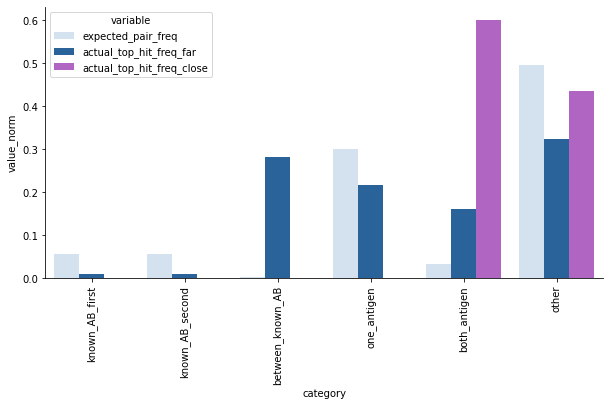

In [47]:
### Combine all three into bar plot
def _process_result_df(result_df):
    cats_to_remove = ["between_maybe_AB", "maybe_AB_first", "maybe_AB_second"]
    result_df = result_df.query("category not in @cats_to_remove")

    desired_order = ["known_AB_first", "known_AB_second", "between_known_AB", "one_antigen","both_antigen",  "other"]


    to_plot = result_df.melt(["category"])
    to_plot["category_sorter"] = [desired_order.index(x) for x in to_plot.category]
    #to_plot["value"] = [np.log10(x) for x in to_plot.value]

    # normalize the result dataframe
    to_plot["value_norm"] = to_plot.value / (to_plot.value.sum()/2)
    
    return to_plot

pal = sns.color_palette("Blues",4)

results_df1_far["category"] = results_df3_far.index

toplot1 = _process_result_df(results_df1_far).fillna(0)
toplot2 = _process_result_df(results_df3_close).fillna(0)
toplot3 = _process_result_df(results_df3_far).fillna(0)

to_plot = pd.concat([toplot1, toplot2, toplot3])

categories_to_keep = ["expected_pair_freq", "actual_top_hit_freq_far", "actual_top_hit_freq_close"]
to_plot = to_plot.query("variable in @categories_to_keep")

desired_order = ["expected_pair_freq", "actual_top_hit_freq_far",  "actual_top_hit_freq_close"]
to_plot["sorter"] = [desired_order.index(x) for x in to_plot.variable]
to_plot = to_plot.sort_values(["sorter", "category_sorter"])


fig= plt.figure(figsize=(10,5))
ax = fig.gca()

sns.barplot(data = to_plot, x='category', y = 'value_norm', hue='variable',
            palette=[pal[0], pal[3],"mediumorchid"]
            
           )
plt.xticks(rotation=90)
#cs = chisquare(top_hits_values,  f_exp=all_hits_expectation)

sns.despine()
plt.savefig("figures/simultaneous_mutations_far_category.pdf")